# Colab Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Upload kaggle.json file
from google.colab import files
files.upload()

In [ ]:
!pip install -q kaggle
!pip install -q pydub
!pip install -q transformers
!pip install -q tensorboard

!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification
!unzip -q gtzan-dataset-music-genre-classification.zip
!mv Data data
!mv data/genres_original data/audio

# jazz.00054.wav is corrupted so we need to delete it
!rm ./data/audio/jazz/jazz.00054.wav

In [ ]:
# Set this to drive location of colab_version
%cd /content/drive/MyDrive/DL/colab_version

from utils import set_data_root_dir
set_data_root_dir('/content')

# Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [48]:
import torch

from utils.train_utils import train, load_model
from utils.data_utils import setup_dataset, read_into_df, get_train_val, RawDS
from models.CombinedClassifier import CombinedClassifier, ASTPipeline
from models.CNNClassifier import CNNClassifier
from utils.analysis_utils import eval, gen_confusion_matrix, gen_tsne, gen_saliency

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device: %s" % device)

Using device: cuda


In [4]:
setup_dataset()
df = read_into_df()
class_map = dict(zip(df.labelId,df.label))
df.head()

Dataset already setup!


,file,label,labelId
0,/home/gigachad/DeepLearningProject/utils/../da...,jazz,5
1,/home/gigachad/DeepLearningProject/utils/../da...,jazz,5
2,/home/gigachad/DeepLearningProject/utils/../da...,jazz,5
3,/home/gigachad/DeepLearningProject/utils/../da...,jazz,5
4,/home/gigachad/DeepLearningProject/utils/../da...,jazz,5


# Combined Classifier

In [ ]:
dataset = RawDS(df)
train_dl, val_dl = get_train_val(dataset, train_split=0.8, batch_size=8)

model = CombinedClassifier(device)
model.to(device)

num_epochs = 20
lr = 0.001
train(model, train_dl, val_dl, num_epochs, lr, device, 'CombinedClassifier')

In [55]:
model = CombinedClassifier(device)
model = model.to(device)
data = next(iter(val_dl))[0]
data.requires_grad = True

Some weights of the model checkpoint at bookbot/distil-ast-audioset were not used when initializing ASTModel: ['classifier.layernorm.weight', 'classifier.layernorm.bias', 'classifier.dense.weight', 'classifier.dense.bias']
- This IS expected if you are initializing ASTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ASTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [58]:
model(data)

combined torch.Size([8, 1288])


tensor([[-8.7058e-01,  5.9162e-01, -5.2081e-01, -1.1821e-01, -9.6421e-01,
         -2.2069e-01,  2.9009e-01, -9.5899e-01, -1.0546e+00, -1.6374e+00],
        [ 1.0724e-02,  1.0300e-02,  1.5734e-01, -3.0877e-03, -8.2279e-01,
         -2.3462e-01,  3.8942e-01, -2.5231e-01, -3.8963e-01, -6.8000e-01],
        [ 2.1108e-01,  6.8578e-02,  1.6717e-01, -5.8163e-01, -7.0046e-01,
          3.1625e-02,  3.0342e-01,  2.0632e-01, -7.2491e-01, -2.5967e-01],
        [ 1.5571e-04,  1.0741e+00, -3.5944e-01, -7.6145e-02, -9.0975e-01,
          1.7617e-01, -6.6822e-03, -9.5549e-01, -1.2675e+00,  3.5806e-01],
        [ 1.5772e-01,  1.1056e-01, -1.2497e-01, -5.6005e-02, -2.6339e-01,
          9.5287e-02, -2.1746e-01, -3.1530e-01, -2.2905e-01, -2.2621e-01],
        [-6.4361e-02,  3.0087e-01, -6.3197e-03, -2.1962e-01, -4.4209e-01,
         -1.5538e-01, -8.1725e-01, -9.6353e-03, -2.1525e-01,  5.0907e-02],
        [ 3.1551e-01, -3.4277e-01,  1.4911e-01, -4.9215e-01, -5.5480e-01,
          2.1246e-01, -6.1885e-0

# Evaluation

In [5]:
model = CombinedClassifier(device)
load_model('ast_audio_classifier.pt', model)
model.to(device)

Some weights of the model checkpoint at bookbot/distil-ast-audioset were not used when initializing ASTModel: ['classifier.layernorm.weight', 'classifier.layernorm.bias', 'classifier.dense.weight', 'classifier.dense.bias']
- This IS expected if you are initializing ASTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ASTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


CombinedClassifier(
  (ast_pipeline): ASTPipeline()
  (ast_model): ASTModel(
    (embeddings): ASTEmbeddings(
      (patch_embeddings): ASTPatchEmbeddings(
        (projection): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ASTEncoder(
      (layer): ModuleList(
        (0-5): 6 x ASTLayer(
          (attention): ASTAttention(
            (attention): ASTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ASTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ASTIntermediate(
            

In [6]:
dataset = RawDS(df)
train_dl, val_dl = get_train_val(dataset, train_split=0.8, batch_size=8)

In [22]:
values = eval(model, val_dl, ['relu2'])

  0%|          | 0/150 [00:00<?, ?it/s]

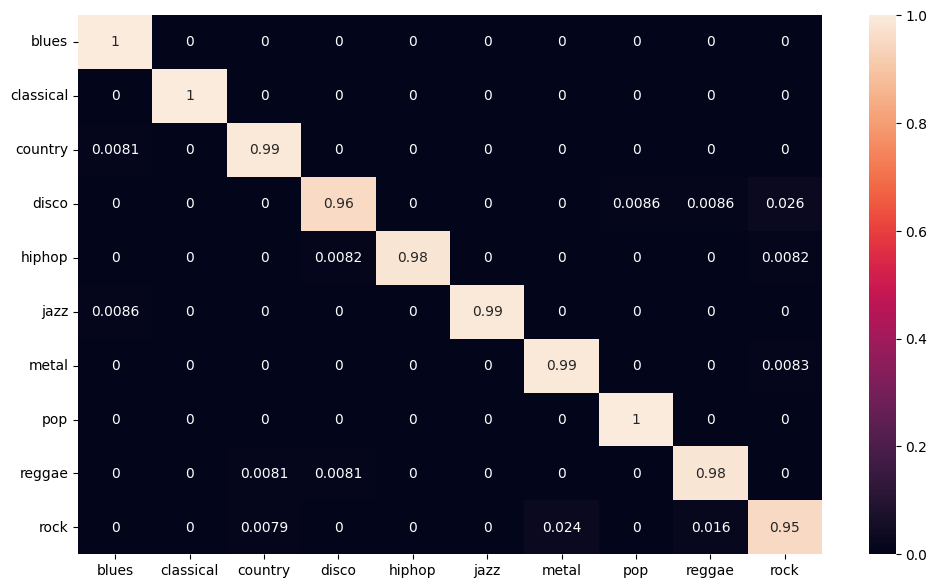

In [21]:
gen_confusion_matrix(values['label'], values['pred'], class_map)

In [7]:
gen_tsne(['relu2'], values, class_map)

NameError: name 'values' is not defined

In [7]:
gen_saliency(model, '/home/gigachad/DeepLearningProject/data/samples/country/0_country.00002.wav', device)

True
forward False
tensor([[ -2.6126, -10.9486,   5.4568, -14.2273,  -6.8401,  -2.4020,  -8.2610,
          -8.9509,  -3.7262,   2.1082]], device='cuda:0')
forward False


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn